##### **Problem:** <br>
Predict company bankrupty based on their financial ratios

##### **Dataset:** <br>
The dataset is obtained from Kaggle: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction <br>
The data contains financial information and bankruptcy
status of ~7000 Taiwanese companies that were on the Taiwan Stock Exchange from 1999-2009. The
companies belonged to various industries including manufacturing, electronics, service, and more. For each
company, there are 97 input variables including total asset turnover, current liability to assets, equity to
liability, etc. Each of the variables has been normalized into the range from
0 to 1. Additionally, there is one dependent variable indicating the bankruptcy status, 0 viable and 1
bankrupt.

##### **Methods:** <br>
1. Data Exploration  
    * 2-3% of companies are bankrupt, which indicates there is imbalanced data

2. Data wrangling
    * Remove " Liability-Assets Flag", " Net Income Flag" categorical columns, as their meanings are unclear
  
3. Model Building
    * Conducted principled training/test data splitting adhering to a 75/25 ratio for rigorous model evaluation.
    * Addressed class imbalance issue using Synthetic Minority Oversampling Technique (SMOTE) to ensure equitable representation.
    * Employed Principal Component Analysis (PCA) and Kernel PCA to address interdependencies among financial data and reduce dimensionality.
    * Utilized logistic regression with regularization, PCA eigenvectors, and kernel tricks to enhance model robustness (This was done by other team members).
    * Implemented K-Nearest Neighbors (KNN) algorithm for dichotomous categorization of companies into bankrupt and viable classes (This was done by other team members).
    * Built random forest models to capture nonlinearity effectively in the data (this notebook).

4. Model Evaluation 
    * Prioritized recall rate in model performance evaluation to enhance bankruptcy detection effectiveness and minimize false negatives.
    * Utilized confusion matrix and Precision-Recall Curve (PR-AUC) for comprehensive evaluation of model predictive capacity and discriminatory ability.
    * After applying SMOTE to address class imbalance, we constructed several random forest models using different combinations of PCA (Principal Component Analysis) and kernel methods. Specifically, the following models were built:
        - SMOTE RF
        - SMOTE/LinearPCA RF
        - SMOTE/SigmoidPCA RF
        - SMOTE/cosine RF
        - SMOTE/rbf RF
        - SMOTE/poly RF <br>
        
Among these models, the SMOTE RF model achieved the highest area under the curve for precision-recall (AUC-PR) with a value of 0.33. This suggests that the random forest approach may not be the most suitable model for predicting bankruptcy for this dataset.
        
##### **Takeways:** <br>


In [63]:
#import libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report, f1_score,make_scorer, recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from matplotlib.colors import ListedColormap
from sklearn import tree
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns

**Data Preprocessing**
* Remove unneccessary columns
* Divide the data into 75/25 training/testing data
* Apply SMOTE to correct for imbalance data

In [27]:
df = pd.read_csv("Bankruptcy_data.csv")
#split the data into x and y. Using all data including outliers
y = df['Bankrupt?']
x =df.iloc[:, 1:]

#remove columns ( Liability-Assets Flags, Net Income Flags) from x
x = x.drop(columns=[" Liability-Assets Flag", " Net Income Flag"], axis =1)

#split data into 75/25 training/test
X_train, X_test,y_train, y_test = train_test_split(x, y,
                                random_state=104,
                                test_size=0.25,
                                shuffle=True)

#SMOTE for training data and test data
smt=SMOTE()
x_train_sm,y_train_sm=smt.fit_resample(X_train,y_train)

**Model Building - Random Forest on original data (No SMOTE)**

In [28]:
#Build random forest model w/original data, no modifications
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#assumptions: criterion:gini,

n_estimators = list(np.arange(20,500,20))

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4,6,8,10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

#maximize recall
scorer = make_scorer(recall_score)

#perform random search training
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring=scorer, n_iter = 50, cv = 5, verbose=2, random_state=104, n_jobs = -1)
rf_random.fit(X_train, y_train)

{'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200, 220, 240, 260,
                                                         280, 300, 320, 340,
                                                         360, 380, 400, 420,
                                                         440, 460, 480]},
                   random_state=104, scoring=make_scorer(recall_score),
                   verbose=2)

Best model from random search
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1661
           1       0.54      0.16      0.25        44

    accuracy                           0.97      1705
   macro avg       0.76      0.58      0.62      1705
weighted avg       0.97      0.97      0.97      1705



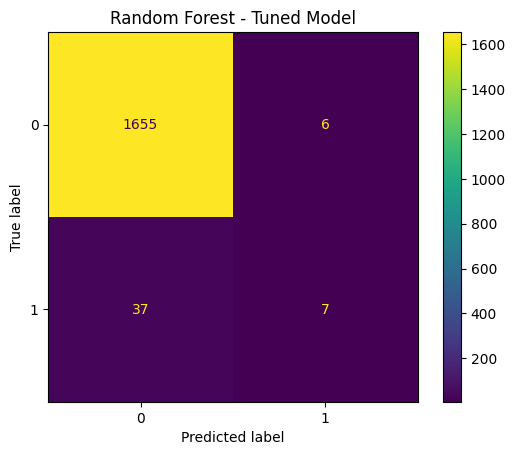

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1661
           1       0.53      0.18      0.27        44

    accuracy                           0.97      1705
   macro avg       0.76      0.59      0.63      1705
weighted avg       0.97      0.97      0.97      1705



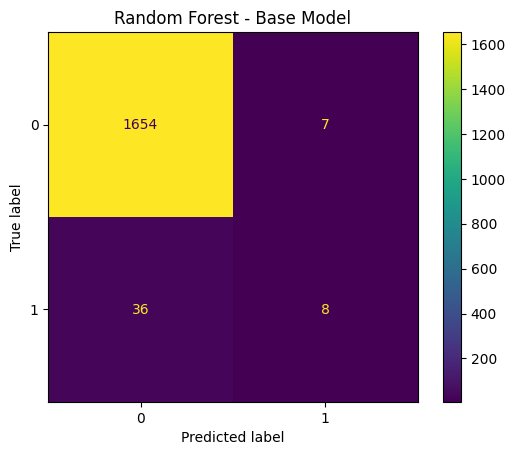

In [29]:
#the best parameters from fitting the random search
print("Best model from random search")
print(rf_random.best_params_)

#evaluate the best model
best_model_rand = rf_random.best_estimator_

# Evaluate the best model on test data
y_pred_rand = best_model_rand.predict(X_test)  # X_test is your test data
rand_report = classification_report(y_test, y_pred_rand)
print(rand_report)

#plot confusion matrix
cm_ori = confusion_matrix(y_test, y_pred_rand )
cm_ori_display = ConfusionMatrixDisplay(confusion_matrix = cm_ori)
cm_ori_display.plot()
plt.title("Random Forest - Tuned Model")
plt.show()

#make a base model and see if performance of model from random search is better
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
base_report = classification_report(y_test, y_pred_base)
print(base_model.get_params())
print(base_report)

#plot confusion matrix 
cm_base = confusion_matrix(y_test, y_pred_base )
cm_base_display = ConfusionMatrixDisplay(confusion_matrix = cm_base)
cm_base_display.plot()
plt.title("Random Forest - Base Model")
plt.show()
 

In [77]:
report = classification_report(y_test,y_pred_base , output_dict=True)
display(pd.DataFrame(report).transpose())

,precision,recall,f1-score,support
0,0.978698,0.995786,0.987168,1661.00000
1,0.533333,0.181818,0.271186,44.00000
accuracy,0.974780,0.974780,0.974780,0.97478
macro avg,0.756016,0.588802,0.629177,1705.00000
weighted avg,0.967205,0.974780,0.968691,1705.00000


In [30]:
#further fine tune parameters using gridsearchcv
param_grid = {
 
    'max_depth': [70, 80, 90, 100, 110],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4,6,8],
    'n_estimators': [60,80,100,120]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [70, 80, 90, 100, 110],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [60, 80, 100, 120]},
             verbose=2)

In [31]:
#best random forest model from gridsearchcv
print(grid_search.best_params_)

#evaluate the best model
best_model_grid = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred_grid = best_model_grid.predict(X_test)   
grid_report = classification_report(y_test, y_pred_grid )
print(grid_report)

{'max_depth': 110, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1661
           1       0.53      0.18      0.27        44

    accuracy                           0.97      1705
   macro avg       0.76      0.59      0.63      1705
weighted avg       0.97      0.97      0.97      1705



**Model Building - Random Forest + SMOTE** <br>
We performed SMOTE on the dataset before building the random forest model. We used RandomGridSearch to narrow down the hyperparameters to tune. Some of the hyperparameters were the same as the default settings. The tuned model performed the same as the base model, so we did not run GridSearchCV.  

In [ ]:
#build model w/smote + RF using randomsearchcv
rf = RandomForestClassifier()
rf_random_sm= RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring=scorer, n_iter = 50, cv = 5, verbose=2, random_state=104, n_jobs = -1)
rf_random_sm.fit(x_train_sm, y_train_sm)

#the best parameters from fitting the random search  (SMOTE)
print("Best model from random search - SMOTE")
print(rf_random_sm.best_params_)

#evaluate the best model
best_model_rand_sm = rf_random_sm.best_estimator_

# Evaluate the best model on test data
y_pred_rand_sm = best_model_rand_sm.predict(X_test)  # X_test is your test data
rand_report_sm = classification_report(y_test, y_pred_rand_sm)
print(rand_report_sm)

 

,precision,recall,f1-score,support
0,0.987783,0.973510,0.980594,1661.000000
1,0.352941,0.545455,0.428571,44.000000
accuracy,0.962463,0.962463,0.962463,0.962463
macro avg,0.670362,0.759482,0.704583,1705.000000
weighted avg,0.971400,0.962463,0.966349,1705.000000


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'0': {'precision': 0.9877825290164935, 'recall': 0.9735099337748344, 'f1-score': 0.9805942995755004, 'support': 1661.0}, '1': {'precision': 0.35294117647058826, 'recall': 0.5454545454545454, 'f1-score': 0.42857142857142855, 'support': 44.0}, 'accuracy': 0.9624633431085043, 'macro avg': {'precision': 0.6703618527435409, 'recall': 0.7594822396146899, 'f1-score': 0.7045828640734645, 'support': 1705.0}, 'weighted avg': {'precision': 0.9713995263701476, 'recall': 0.9624633431085043, 'f1-score': 0.9663485480657178, 'support': 1705.0}}


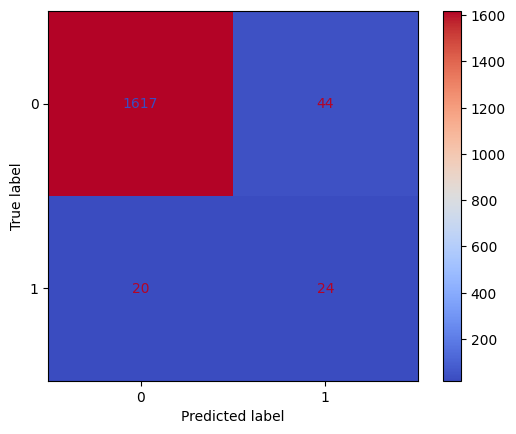

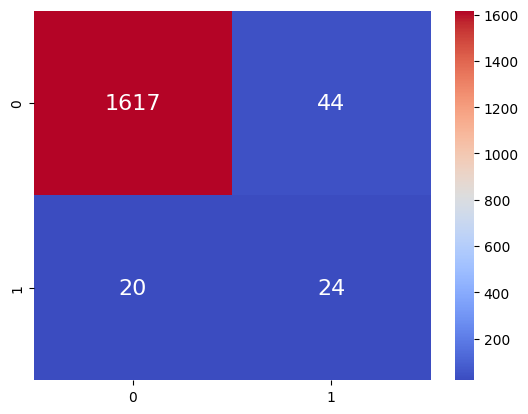

In [71]:
#make a base model and see if performance of model from random search is better
base_model_sm = RandomForestClassifier()
base_model_sm.fit(x_train_sm, y_train_sm)
y_pred_base_sm = base_model_sm.predict(X_test)
base_report_sm = classification_report(y_test, y_pred_base_sm, output_dict=True)
display(pd.DataFrame(base_report_sm).transpose())
print(base_model_sm.get_params())
print(base_report_sm)


#plot confusion matrix of smote base model
cm_base_sm = confusion_matrix(y_test, y_pred_base_sm)
cm_base_sm_display = ConfusionMatrixDisplay(confusion_matrix = cm_base_sm)
cm_base_sm_display.plot(cmap='coolwarm')
#plt.title("Random Forest - SMOTE Base Model")
plt.show()

 
sns.heatmap(cm_base_sm, annot=True, fmt='d', cmap='coolwarm', annot_kws={'size': 16})

plt.show()

**Model Building - Random Forest on original data (No SMOTE) combined with PCA** <br>
For PCA, we want to take the first k eigenvectors that capture >= at least 85% of the total variance <br>
References:<br>
* https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/ <br>
* https://towardsdatascience.com/machine-learning-step-by-step-6fbde95c455a

Notes:
For the confusion matrix, when ``true positive + false positive == 0``, precision is undefined.   When ``true positive + false negative == 0``, recall is undefined.   In such cases, by default the metric will be set to 0, as will f-score,   and ``UndefinedMetricWarning`` will be raised.  

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1661
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1705
   macro avg       0.49      0.50      0.49      1705
weighted avg       0.95      0.97      0.96      1705



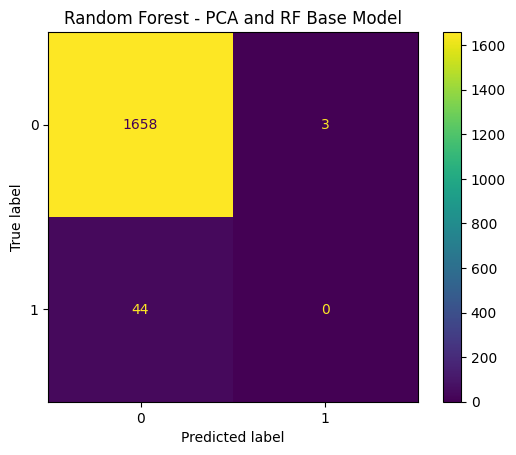

In [34]:
#pca & random forest - original data

#perform PCA on original data
pca = PCA(n_components=20, random_state=104)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#plot the total variance explained as we add more components
'''sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=7, ymin=0, ymax=1)
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))'''

#build base model w/pca
base_pca = RandomForestClassifier()
base_pca.fit(X_train_pca, y_train)

y_pred_base_pca = base_pca.predict(X_test_pca)
base_report_pca = classification_report(y_test, y_pred_base_pca)
print(base_pca.get_params())
print(base_report_pca)

#plot confusion matrix of smote base model
cm_base_pca = confusion_matrix(y_test, y_pred_base_pca)
cm_base_pca_display = ConfusionMatrixDisplay(confusion_matrix = cm_base_pca)
cm_base_pca_display.plot()
plt.title("Random Forest - PCA and RF Base Model")
plt.show()


In [35]:
#randomgrid search on pca data + random forest
rf = RandomForestClassifier()
rf_random_pca = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring=scorer, n_iter = 50, cv = 5, verbose=2, random_state=104, n_jobs = -1)
rf_random_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200, 220, 240, 260,
                                                         280, 300, 320, 340,
                                                         360, 380, 400, 420,
                                                         440, 460, 480]},
                   random_state=104, scoring=make_scorer(recall_score),
                   verbose=2)

In [36]:
##randomgrid search on pca data + random forest
print(rf_random_pca.best_params_)

#evaluate the best model
best_model_rand_pca = rf_random_pca.best_estimator_

# Evaluate the best model on test data
y_pred_rand_pca = best_model_rand_pca.predict(X_test_pca)  # X_test is your test data
rand_report_pca = classification_report(y_test, y_pred_rand_pca)
print(rand_report_pca)


{'n_estimators': 260, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 110}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1661
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1705
   macro avg       0.49      0.50      0.49      1705
weighted avg       0.95      0.97      0.96      1705



**Model Building: Random Forest + SMOTE + PCA**

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1661
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1705
   macro avg       0.49      0.50      0.49      1705
weighted avg       0.95      0.97      0.96      1705



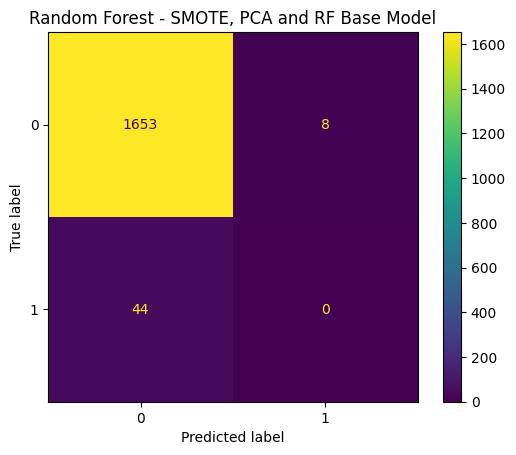

In [39]:
#smote, pca & random forest base model

#perform PCA on smote data
pca2 = PCA(n_components=20, random_state=104)
pca2.fit(x_train_sm)
X_train_sm_pca = pca2.transform(x_train_sm)
X_test_sm_pca = pca2.transform(X_test)

#build base model w/pca & smote
base_pca_sm = RandomForestClassifier()
base_pca_sm.fit(X_train_sm_pca, y_train_sm)

y_pred_base_pca_sm = base_pca.predict(X_test_sm_pca)
base_report_pca_sm = classification_report(y_test, y_pred_base_pca_sm )
print(base_pca_sm.get_params())
print(base_report_pca_sm)

#plot confusion matrix of smote base model
cm_base_pca_sm = confusion_matrix(y_test, y_pred_base_pca_sm)
cm_base_pca_sm_display = ConfusionMatrixDisplay(confusion_matrix = cm_base_pca_sm)
cm_base_pca_sm_display.plot()
plt.title("Random Forest - SMOTE, PCA and RF Base Model")
plt.show()

In [76]:
report = classification_report(y_test, y_pred_base_pca_sm , output_dict=True)
display(pd.DataFrame(report).transpose())

,precision,recall,f1-score,support
0,0.974072,0.995184,0.984515,1661.000000
1,0.000000,0.000000,0.000000,44.000000
accuracy,0.969501,0.969501,0.969501,0.969501
macro avg,0.487036,0.497592,0.492257,1705.000000
weighted avg,0.948935,0.969501,0.959108,1705.000000


In [40]:
#randomsearchcv 
rf3 = RandomForestClassifier()
rf_random_pca_sm = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid, scoring=scorer, n_iter = 50, cv = 5, verbose=2, random_state=104, n_jobs = -1)
rf_random_pca_sm.fit(X_train_sm_pca, y_train_sm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200, 220, 240, 260,
                                                         280, 300, 320, 340,
                                                         360, 380, 400, 420,
                                                         440, 460, 480]},
                   random_state=104, scoring=make_scorer(recall_score),
                   verbose=2)

In [41]:
##randomgrid search on pca data + random forest
print(rf_random_pca_sm.best_params_)

#evaluate the best model
best_model_rand_pca_sm = rf_random_pca_sm.best_estimator_

# Evaluate the best model on test data
y_pred_rand_pca_sm = best_model_rand_pca.predict(X_test_sm_pca)  # X_test is your test data
rand_report_pca_sm = classification_report(y_test, y_pred_rand_pca_sm)
print(rand_report_pca_sm)

{'n_estimators': 380, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1661
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1705
   macro avg       0.49      0.50      0.49      1705
weighted avg       0.95      0.97      0.96      1705



c:\Users\yong2\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yong2\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yong2\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Model Building - RandomForest +SMOTE + Kernel PCA** <br>
Test different kernels for PCA (sigmoid, cosine, rbf, poly) to see if performance can be improved

In [42]:
def get_eigen(n, kernel, X_train, X_test):
  kernel_pca = KernelPCA(n_components=n, kernel=kernel, random_state=104)
  kernel_pca.fit(X_train)
  X_train = kernel_pca.transform(X_train)
  X_test = kernel_pca.transform(X_test)

  return X_train, X_test

In [43]:
number_eigenvectors = 20
sig_X_train, sig_X_test = get_eigen(number_eigenvectors, "sigmoid", x_train_sm, X_test)
cos_X_train, cos_X_test = get_eigen(number_eigenvectors, "cosine", x_train_sm, X_test)
rbf_X_train, rbf_X_test = get_eigen(number_eigenvectors, "rbf", x_train_sm, X_test)
poly_X_train, poly_X_test = get_eigen(number_eigenvectors, "poly", x_train_sm, X_test)

In [75]:
#sigmoid 
rf_sigmoid = RandomForestClassifier(random_state=104)
rf_sigmoid.fit(sig_X_train, y_train_sm)
pred_sigmoid = rf_sigmoid.predict(sig_X_test)
print(classification_report(y_test, pred_sigmoid ))

report = classification_report(y_test, pred_sigmoid  , output_dict=True)
display(pd.DataFrame(report).transpose())


              precision    recall  f1-score   support

           0       1.00      0.02      0.04      1661
           1       0.03      1.00      0.05        44

    accuracy                           0.05      1705
   macro avg       0.51      0.51      0.05      1705
weighted avg       0.97      0.05      0.04      1705



,precision,recall,f1-score,support
0,1.000000,0.022276,0.043581,1661.000000
1,0.026379,1.000000,0.051402,44.000000
accuracy,0.047507,0.047507,0.047507,0.047507
macro avg,0.513189,0.511138,0.047491,1705.000000
weighted avg,0.974874,0.047507,0.043783,1705.000000


In [74]:
#cosine
rf_cosine = RandomForestClassifier(random_state=104)
rf_cosine.fit(cos_X_train, y_train_sm)
pred_cosine = rf_cosine.predict(cos_X_test)
print(classification_report(y_test, pred_cosine ))

report = classification_report(y_test, pred_cosine  , output_dict=True)
display(pd.DataFrame(report).transpose())


              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1661
           1       0.06      0.20      0.09        44

    accuracy                           0.89      1705
   macro avg       0.52      0.56      0.52      1705
weighted avg       0.95      0.89      0.92      1705



,precision,recall,f1-score,support
0,0.977346,0.909091,0.941984,1661.000000
1,0.056250,0.204545,0.088235,44.000000
accuracy,0.890909,0.890909,0.890909,0.890909
macro avg,0.516798,0.556818,0.515110,1705.000000
weighted avg,0.953576,0.890909,0.919952,1705.000000


              precision    recall  f1-score   support

           0       1.00      0.02      0.05      1661
           1       0.03      1.00      0.05        44

    accuracy                           0.05      1705
   macro avg       0.51      0.51      0.05      1705
weighted avg       0.97      0.05      0.05      1705



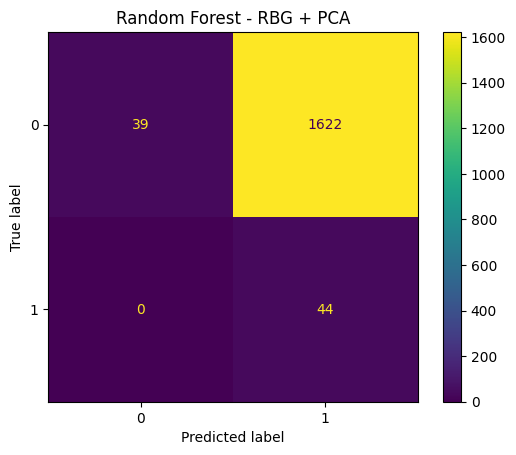

,precision,recall,f1-score,support
0,1.000000,0.02348,0.045882,1661.00000
1,0.026411,1.00000,0.051462,44.00000
accuracy,0.048680,0.04868,0.048680,0.04868
macro avg,0.513205,0.51174,0.048672,1705.00000
weighted avg,0.974875,0.04868,0.046026,1705.00000


In [73]:
#rbg
rf_rbf = RandomForestClassifier(random_state=104)
rf_rbf.fit(rbf_X_train, y_train_sm)
pred_rbf = rf_rbf.predict(rbf_X_test)
print(classification_report(y_test, pred_rbf))

#confusion matrix

ConfusionMatrixDisplay(confusion_matrix(y_test, pred_rbf )).plot()
plt.title("Random Forest - RBG + PCA")
plt.show()

report = classification_report(y_test, pred_rbf , output_dict=True)
display(pd.DataFrame(report).transpose())

In [72]:
#poly
rf_poly = RandomForestClassifier(random_state=104)
rf_poly.fit(poly_X_train, y_train_sm)
predictions_poly = rf_poly.predict(poly_X_test)
print(classification_report(y_test, predictions_poly))


report = classification_report(y_test, predictions_poly , output_dict=True)
display(pd.DataFrame(report).transpose())

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      1661
           1       0.08      0.23      0.12        44

    accuracy                           0.92      1705
   macro avg       0.53      0.58      0.54      1705
weighted avg       0.96      0.92      0.93      1705



,precision,recall,f1-score,support
0,0.978549,0.933775,0.955638,1661.000000
1,0.083333,0.227273,0.121951,44.000000
accuracy,0.915543,0.915543,0.915543,0.915543
macro avg,0.530941,0.580524,0.538794,1705.000000
weighted avg,0.955447,0.915543,0.934123,1705.000000


**Model Evaluation** <br>
Plot the precision recall curves for the models

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score,recall_score

def plot_precision_recall(y_test,X_test, model, name):
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    average_precision = average_precision_score(y_test, y_prob)

    plt.plot(recall, precision, label=f"{name}, Area Under Curve: {round(average_precision, 2)}")

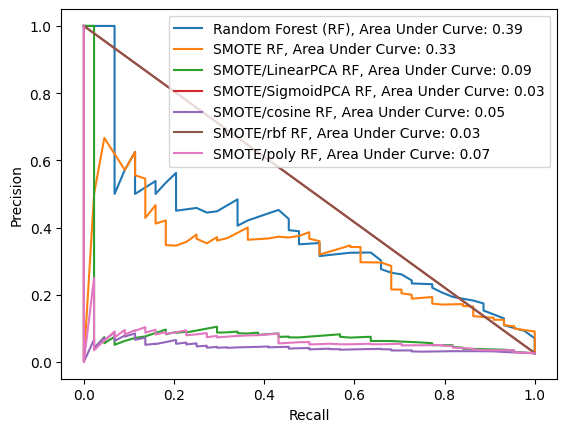

In [53]:
plot_precision_recall(y_test,X_test, base_model, "Random Forest (RF)")
plot_precision_recall(y_test,X_test, base_model_sm, "SMOTE RF")
plot_precision_recall(y_test,X_test_sm_pca , base_pca_sm, "SMOTE/LinearPCA RF")
plot_precision_recall(y_test,sig_X_test, rf_sigmoid, "SMOTE/SigmoidPCA RF")
plot_precision_recall(y_test,cos_X_test, rf_cosine, "SMOTE/cosine RF")
plot_precision_recall(y_test,rbf_X_test, rf_rbf, "SMOTE/rbf RF")
plot_precision_recall(y_test,poly_X_test,rf_poly, "SMOTE/poly RF")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()